In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import median_abs_deviation

#import scvelo as scv

## Pre-Processing ST Data

In [2]:
sc.set_figure_params(facecolor="white", figsize=(6,6))
sc.settings.verbosity = 3

In [3]:
adata = sc.datasets.visium_sge(sample_id="V1_Mouse_Brain_Sagittal_Anterior")

reading C:\Users\sabri\OneDrive - TUM\Desktop\Masterpraktikum\data\V1_Mouse_Brain_Sagittal_Anterior\filtered_feature_bc_matrix.h5
 (0:00:00)


C:\Users\sabri\miniconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\sabri\miniconda3\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [5]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True)
adata

AnnData object with n_obs × n_vars = 2695 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
#sc.pp.calculate_qc_metrics(
    #adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True)
#adata

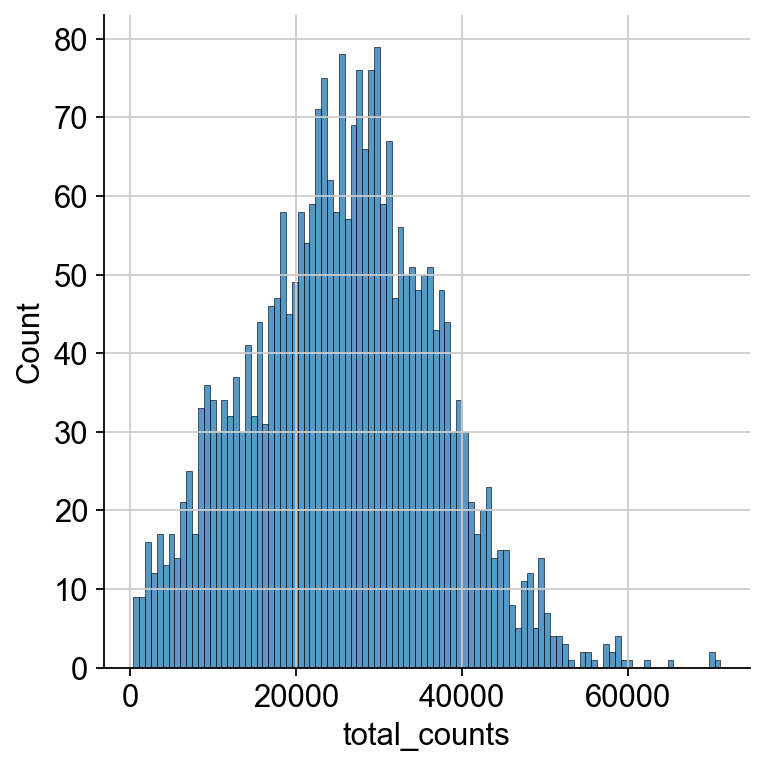

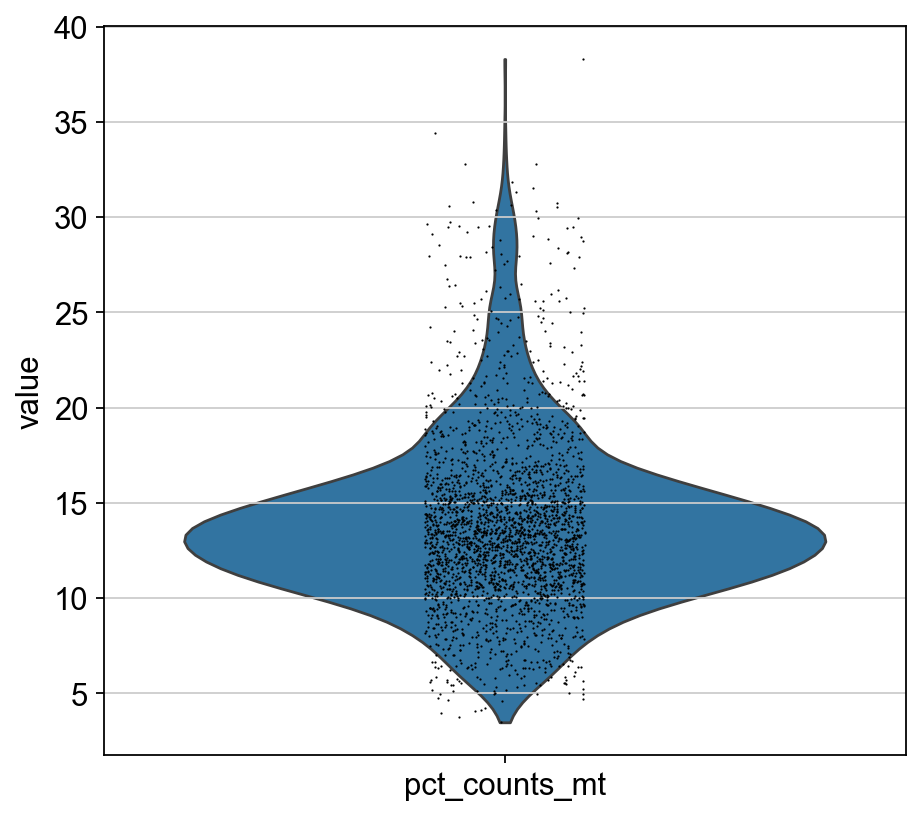

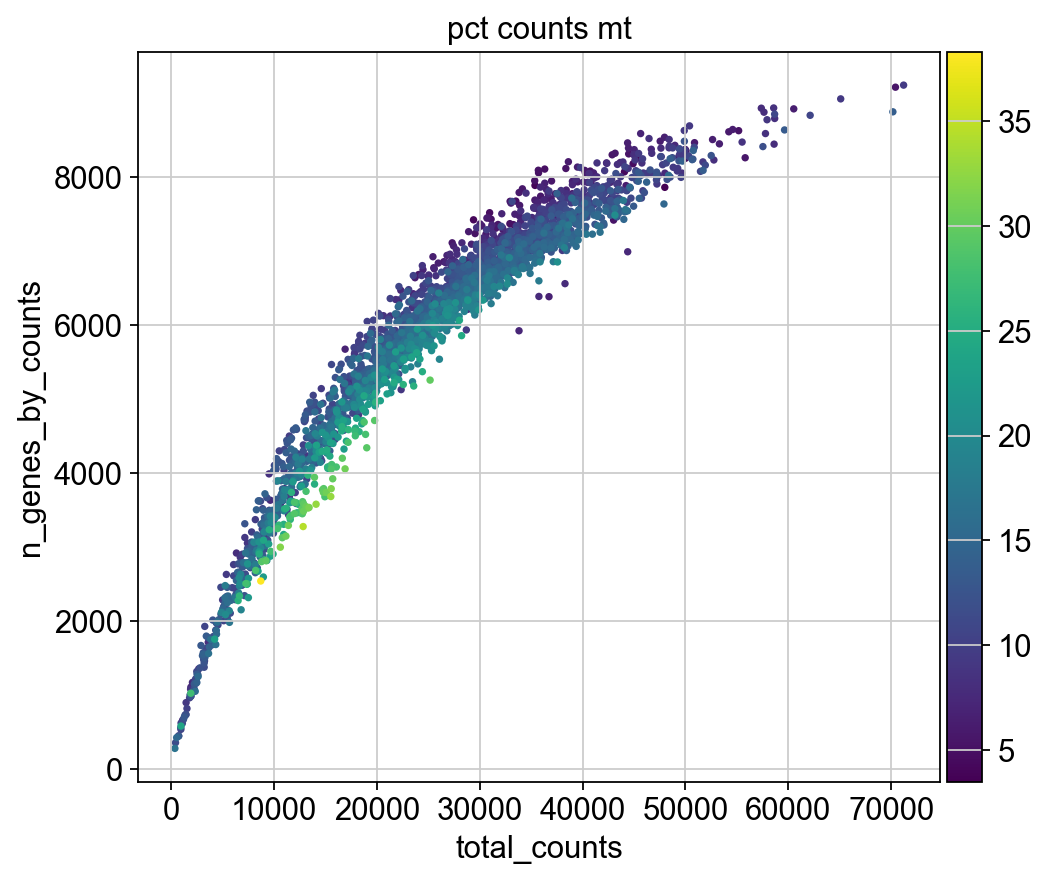

In [7]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata, "pct_counts_mt")
p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

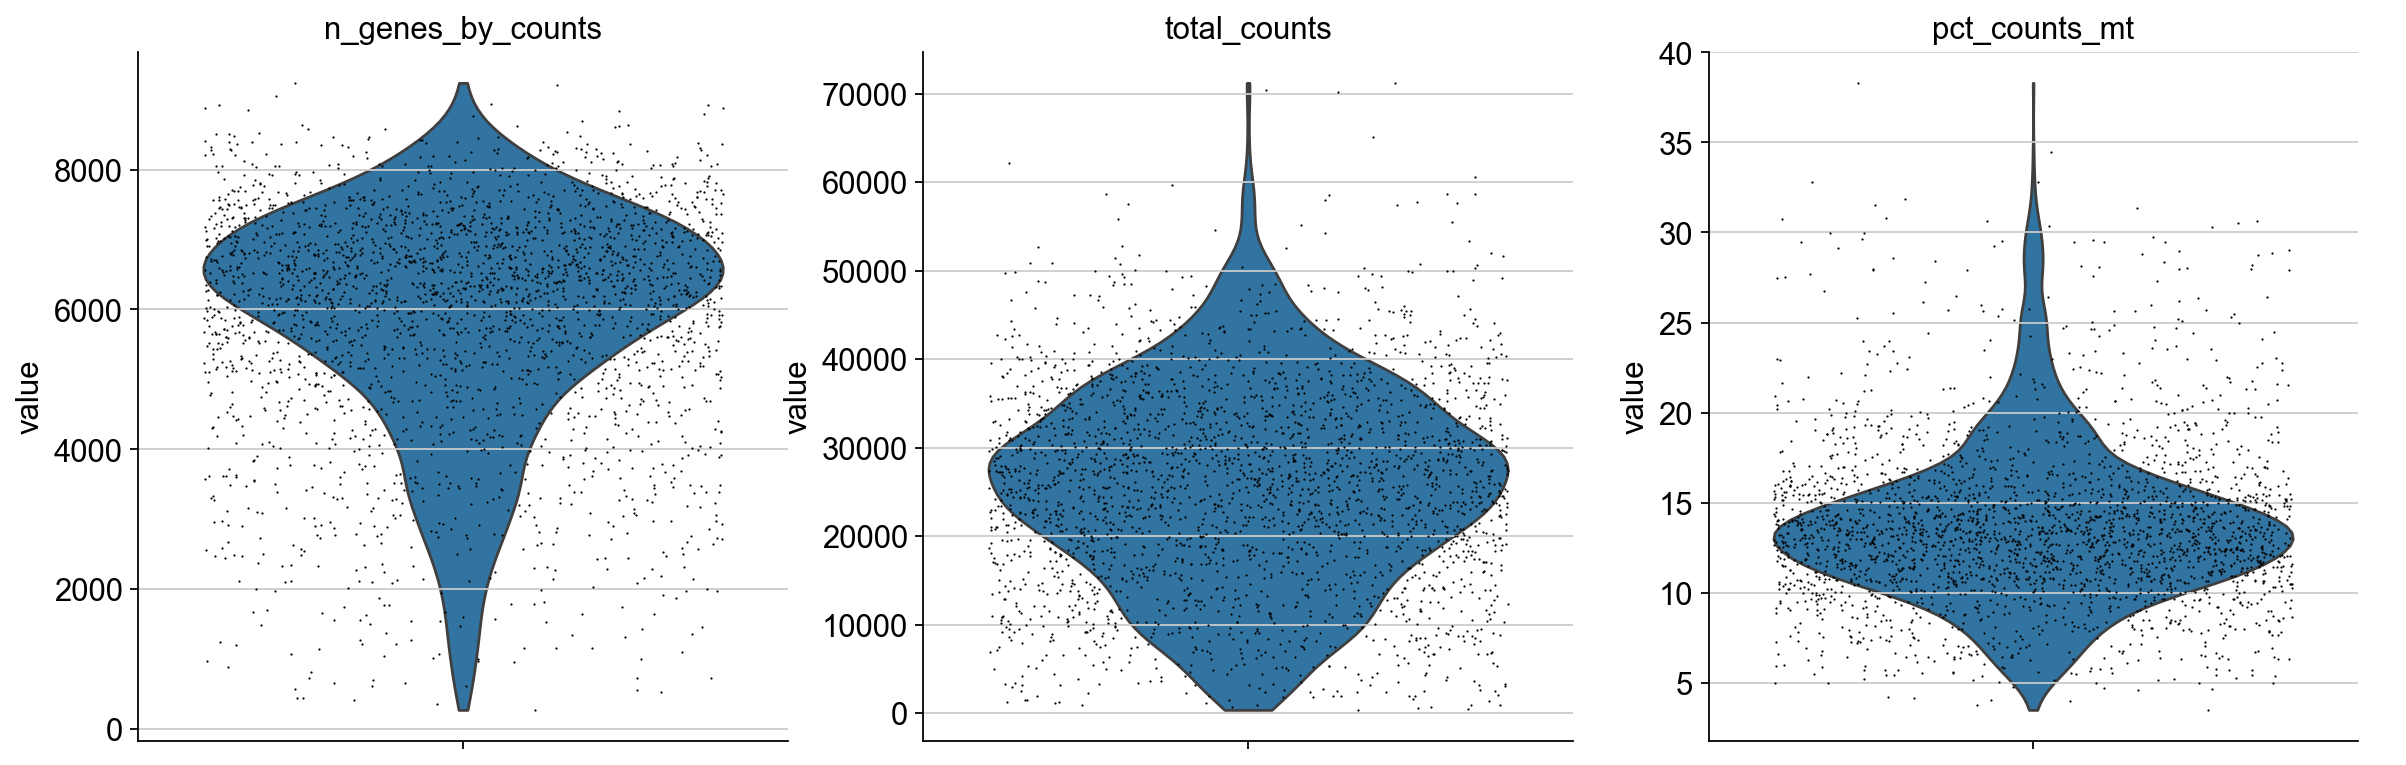

In [8]:
sc.pl.violin(adata, ["n_genes_by_counts","total_counts","pct_counts_mt"], jitter=0.4, multi_panel=True)

In [9]:
adata = adata[adata.obs.n_genes_by_counts > 2000, :]
adata = adata[adata.obs.total_counts < 50000, :]
adata = adata[adata.obs.total_counts > 5000, :]
adata = adata[adata.obs.pct_counts_mt < 25, :]
sc.pp.filter_genes(adata, min_cells=10)

filtered out 15250 genes that are detected in less than 10 cells


C:\Users\sabri\miniconda3\Lib\site-packages\scanpy\preprocessing\_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


In [10]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [11]:
#adata.obs["outlier"] = (
    #is_outlier(adata, "log1p_total_counts", 5)
    #| is_outlier(adata, "log1p_n_genes_by_counts", 5)
    #| is_outlier(adata, "pct_counts_in_top_20_genes", 5)
#)
#adata.obs.outlier.value_counts()

In [12]:
#adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
    #adata.obs["pct_counts_mt"] > 8
#)
#adata.obs.mt_outlier.value_counts()

In [13]:
#print(f"Total number of cells: {adata.n_obs}")
#adata = adata[(~adata.obs.mt_outlier)].copy()

#print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

In [14]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [15]:
adata_pp

AnnData object with n_obs × n_vars = 2500 × 17035
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

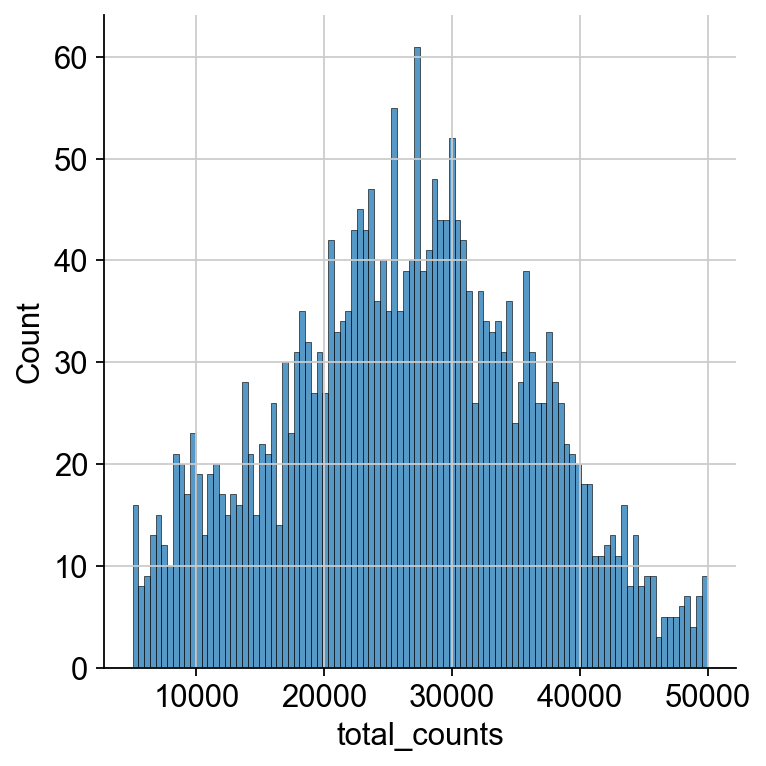

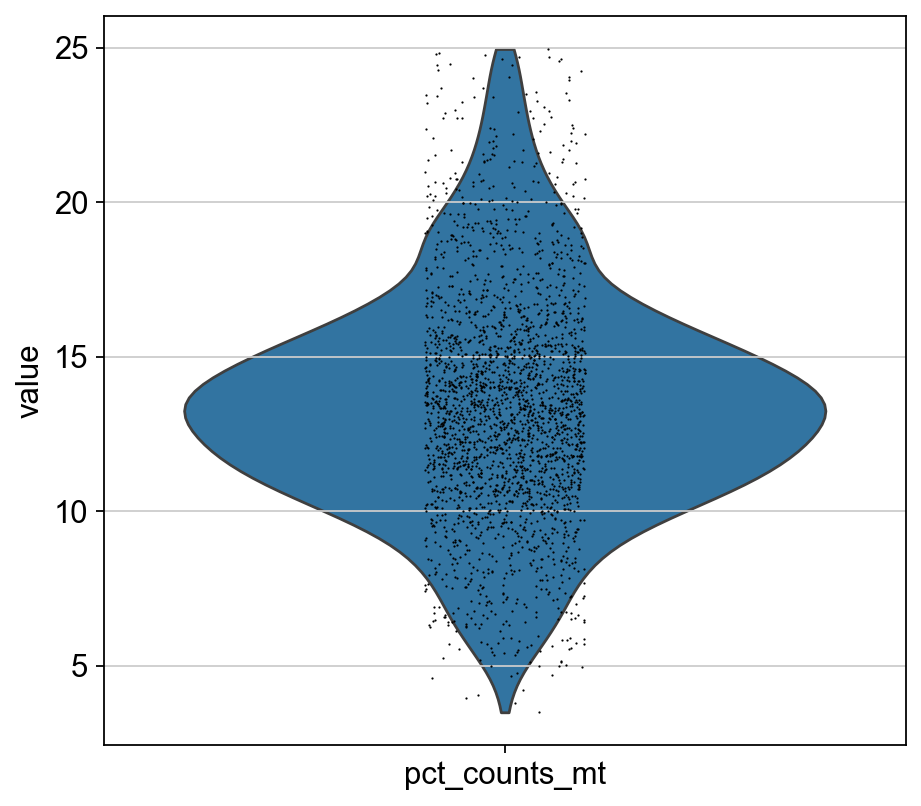

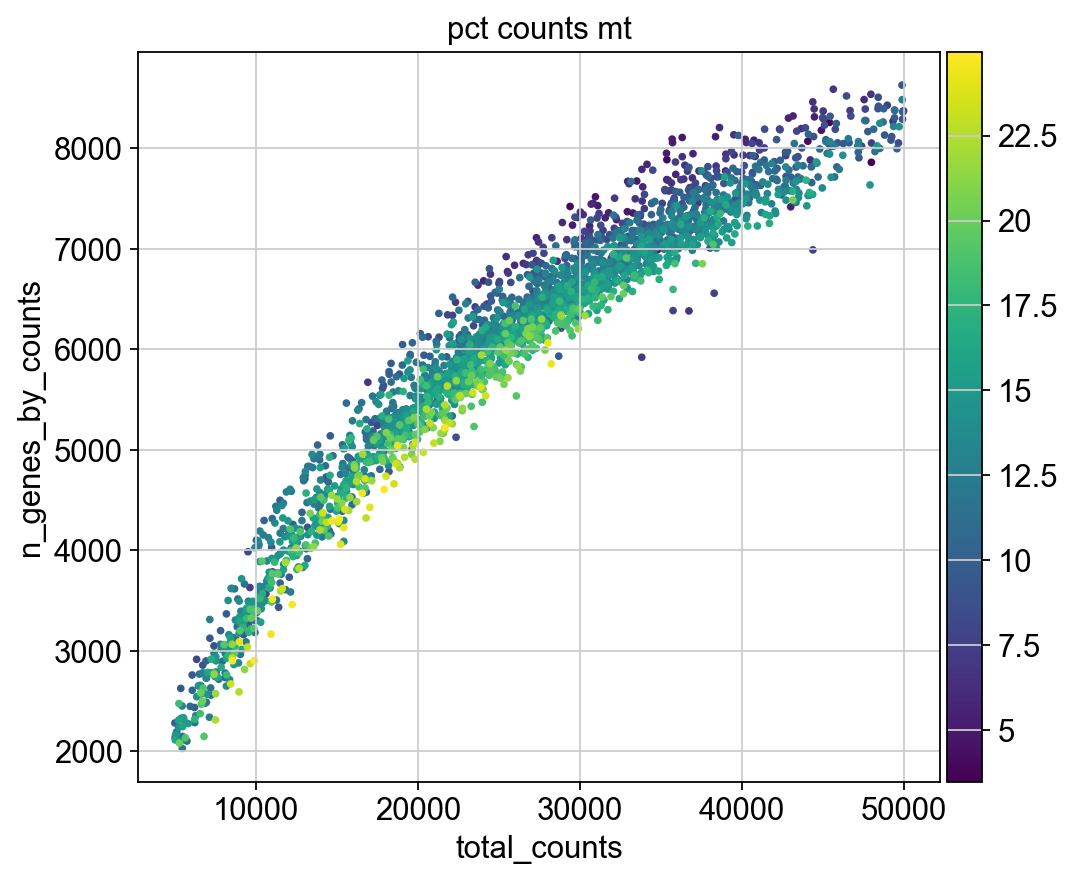

In [16]:
p1 = sns.displot(adata_pp.obs["total_counts"], bins=100, kde=False)
p2 = sc.pl.violin(adata_pp, "pct_counts_mt")
p3 = sc.pl.scatter(adata_pp, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

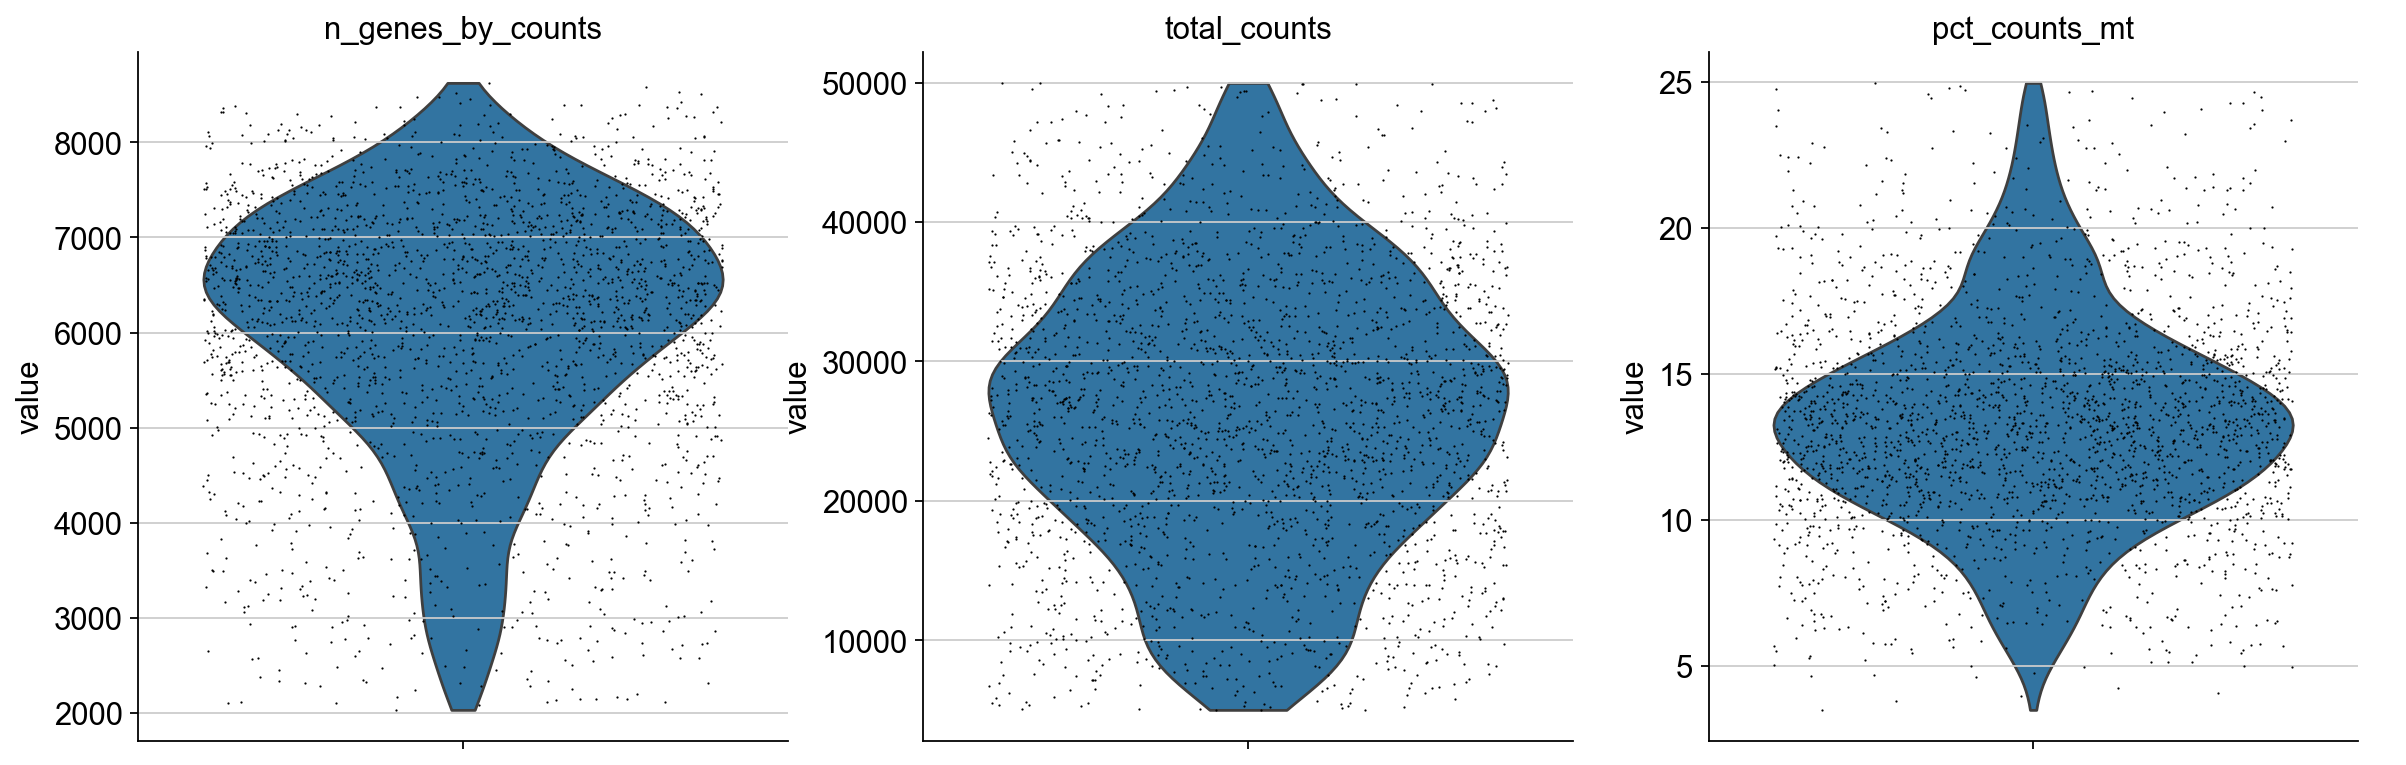

In [17]:
sc.pl.violin(adata_pp, ["n_genes_by_counts","total_counts","pct_counts_mt"], jitter=0.4, multi_panel=True)

#sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [18]:
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="clusters", resolution=0.2)

computing PCA
    with n_comps=50
    finished (0:00:13)
computing neighbors
    using 'X_pca' with n_pcs = 50


C:\Users\sabri\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 7 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


C:\Users\sabri\AppData\Local\Temp\ipykernel_17764\243649576.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_pp, key_added="clusters", resolution=0.2)


In [19]:
sc.tl.umap(adata_pp)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


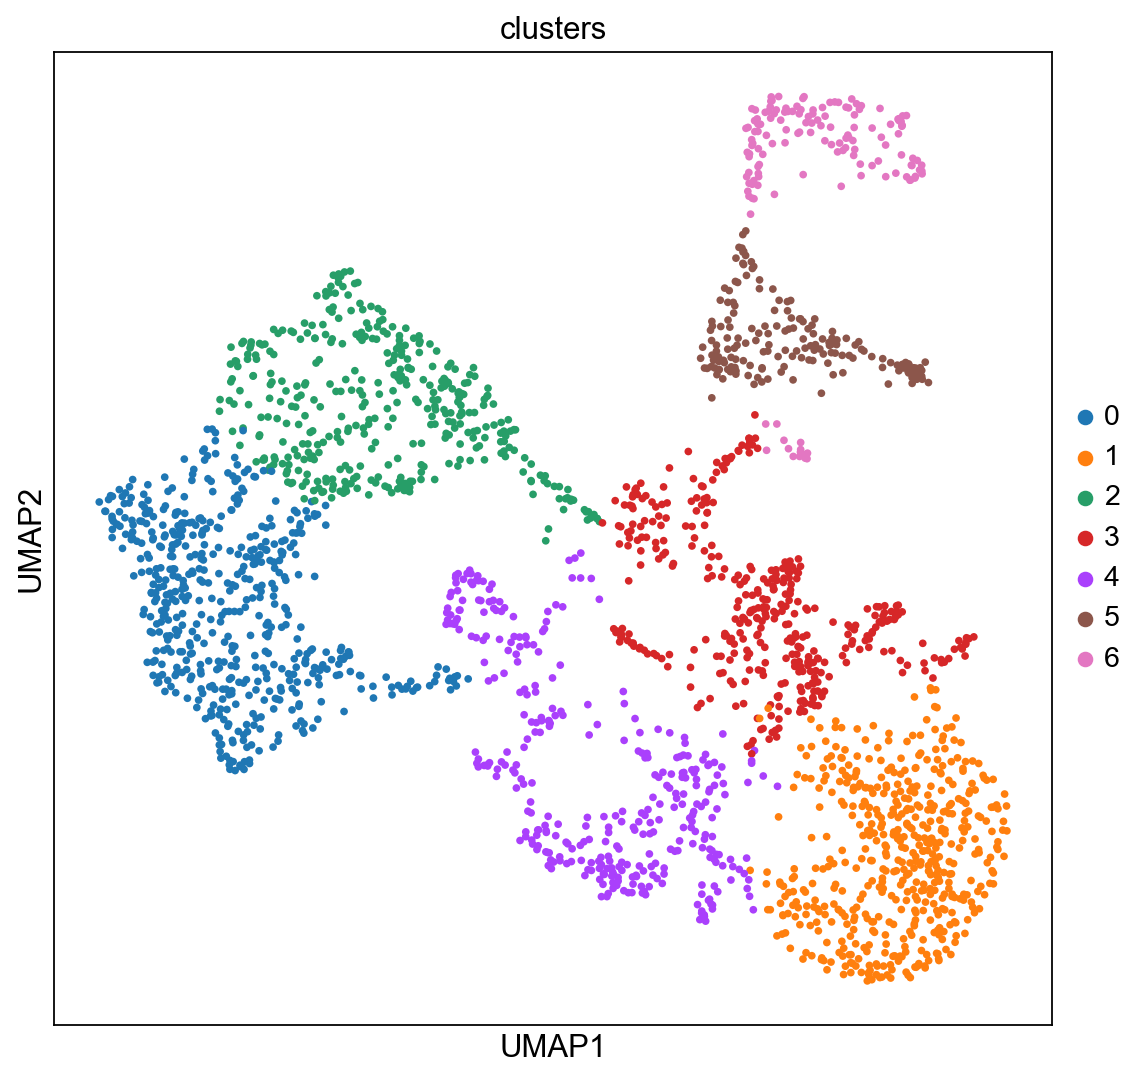

In [20]:
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.umap(adata_pp, color="clusters", wspace=0.4)

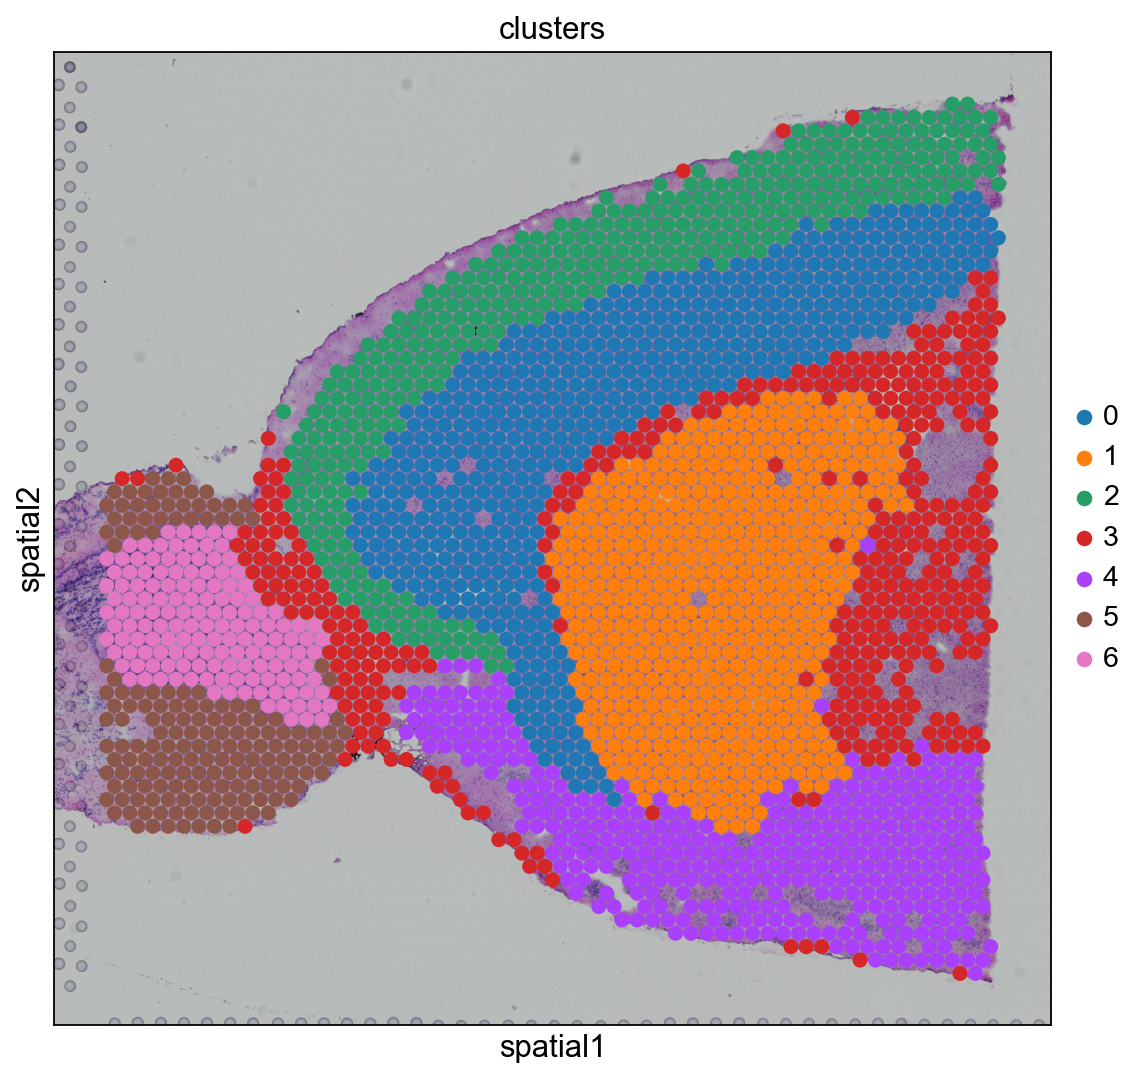

In [21]:
plt.rcParams["figure.figsize"] = (8,8)
sc.pl.spatial(adata_pp, img_key="hires", color="clusters", size=1.5)

In [24]:
sc.write("preprocessed_mouse.h5ad", adata_pp)

## Neigbourhood analysis

In [22]:
import squidpy as sq

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor="white")

In [23]:
adata_pp.obs.keys()

Index(['in_tissue', 'array_row', 'array_col', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts',
       'clusters'],
      dtype='object')

In [24]:
sq.gr.spatial_neighbors(adata_pp)
sq.gr.nhood_enrichment(adata_pp, cluster_key="clusters")

Creating graph using `grid` coordinates and `None` transform and `1` libraries.
Adding `adata.obsp['spatial_connectivities']`
       `adata.obsp['spatial_distances']`
       `adata.uns['spatial_neighbors']`
Finish (0:00:00)
Calculating neighborhood enrichment using `1` core(s)


  0%|          | 0/1000 [00:00<?, ?/s]

Adding `adata.uns['clusters_nhood_enrichment']`
Finish (0:00:11)


In [25]:
adata.uns.keys()

odict_keys(['spatial'])

In [32]:
#adata.uns["spatial_neighbors"]

C:\Users\danie\miniconda3\Lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\danie\miniconda3\Lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


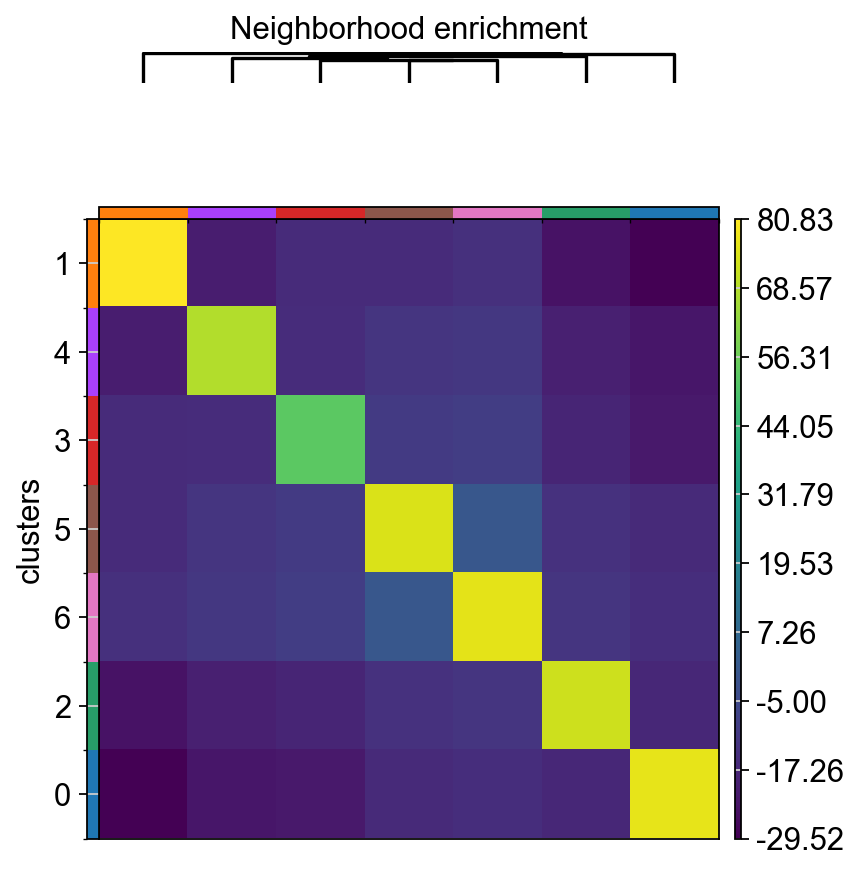

In [27]:
sq.pl.nhood_enrichment(adata_pp, cluster_key="clusters", method="average", figsize=(5, 5))

In [28]:
sq.gr.interaction_matrix(adata_pp, cluster_key="clusters")

Adding `adata.uns['clusters_interactions']`


In [29]:
adata_pp.uns["clusters_interactions"]

array([[2880.,   26.,  157.,   68.,   30.,    0.,    0.],
       [  26., 2852.,    0.,  153.,   47.,    0.,    0.],
       [ 157.,    0., 1982.,   46.,    9.,    0.,    0.],
       [  68.,  153.,   46., 1522.,   65.,   29.,   28.],
       [  30.,   47.,    9.,   65., 1698.,    0.,    0.],
       [   0.,    0.,    0.,   29.,    0.,  842.,   60.],
       [   0.,    0.,    0.,   28.,    0.,   60.,  778.]])

C:\Users\danie\miniconda3\Lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
C:\Users\danie\miniconda3\Lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


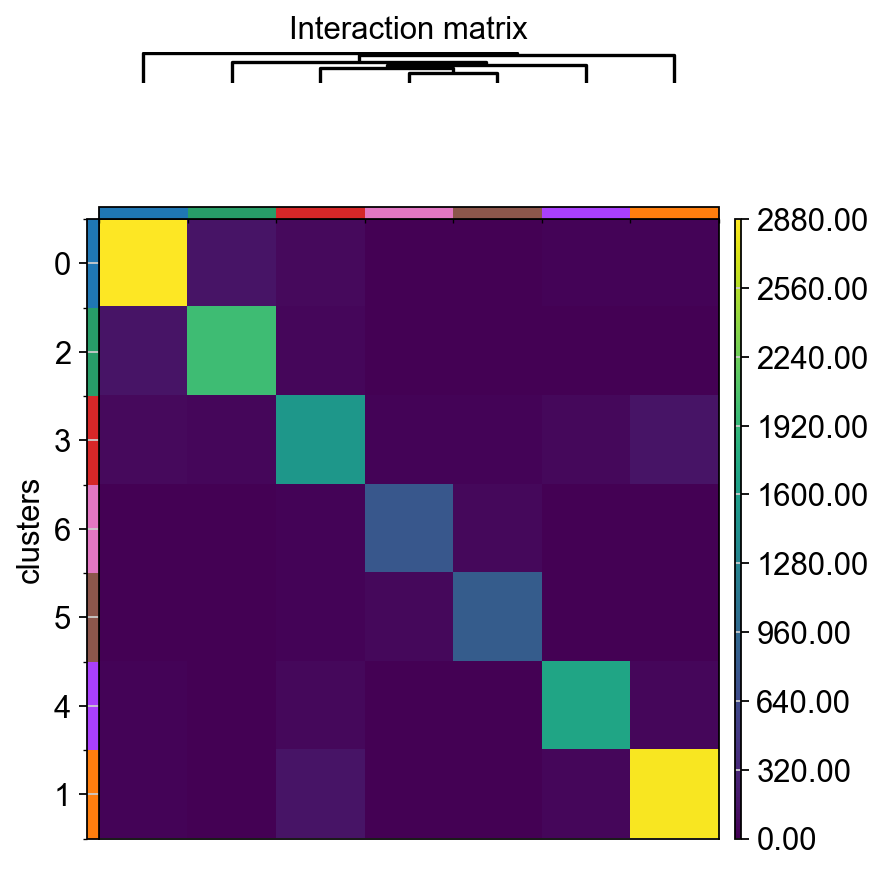

In [30]:
sq.pl.interaction_matrix(adata_pp, cluster_key="clusters", method="average", figsize=(5, 5))

Calculating co-occurrence probabilities for `50` intervals `1` split combinations using `1` core(s)


  0%|          | 0/1 [00:00<?, ?/s]

Adding `adata.uns['clusters_co_occurrence']`
Finish (0:00:10)


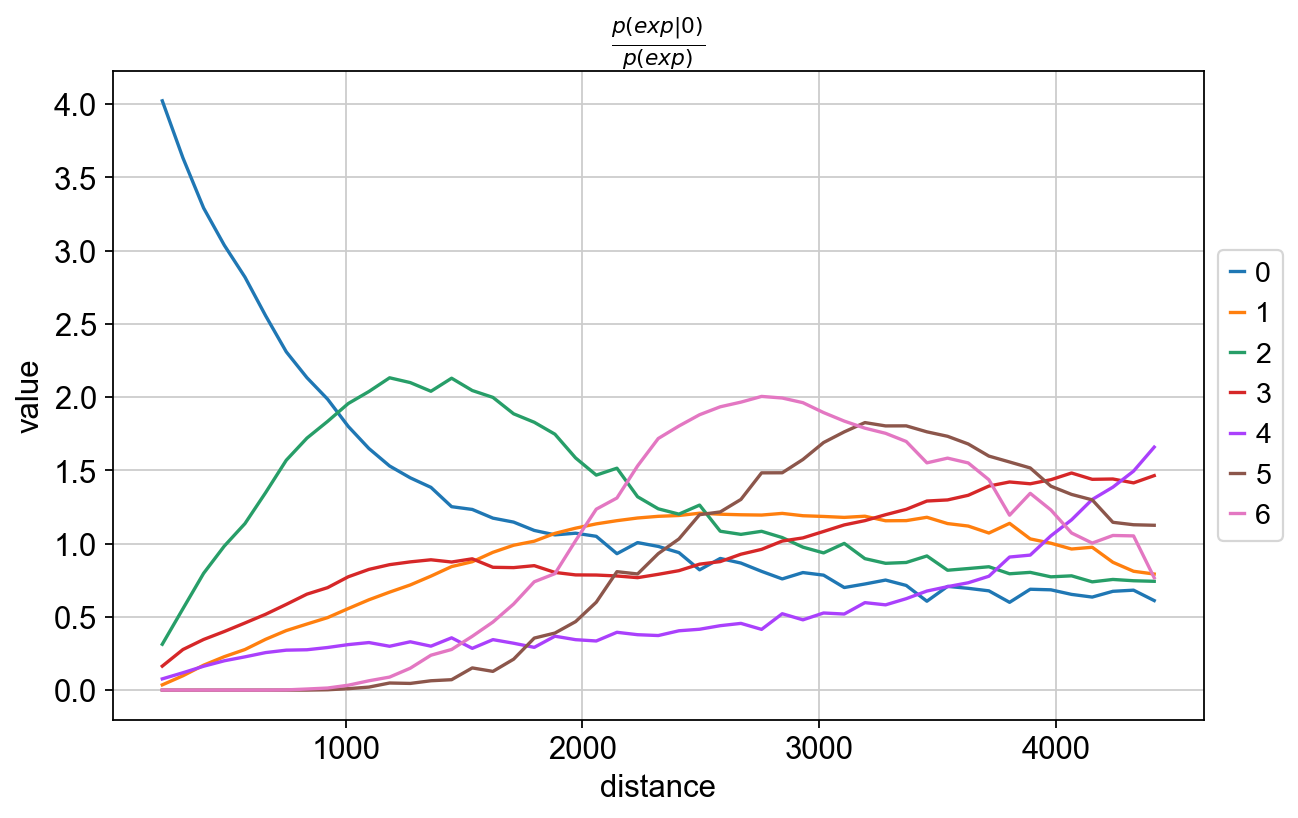

In [31]:
sq.gr.co_occurrence(adata_pp, cluster_key="clusters")
sq.pl.co_occurrence(adata_pp, cluster_key="clusters", clusters="0", figsize=(8, 5))